# MultiModal Alzheimer's Prediction Model: ResNet-18 with SHAP Value Generation and CatBoost

This model leverages the ResNet-18 architecture, a convolutional neural network (CNN) designed for image classification tasks,
 to analyze input data and generate predictions. To interpret the model's predictions, SHAP (SHapley Additive exPlanations) 
 values are computed. SHAP is a explainability technique that assigns each feature an importance value for a particular prediction,
  helping to understand the contribution of each feature to the model's output.

In addition to ResNet-18, the model incorporates CatBoost, a gradient boosting decision tree algorithm, 
to analyze clinical data. By combining SHAP values with CatBoost, the model can effectively interpret the 
clinical features' contributions to the predictions, providing a comprehensive understanding of both imaging 
and clinical data in Alzheimer's diagnosis.


In [240]:
# import all the necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# import the necessary libraries for machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


# import resnet18 model from torchvision
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler, TensorDataset
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import TensorDataset, DataLoader, random_split

# import shap value libraries
import shap
from shap import DeepExplainer, GradientExplainer, KernelExplainer, LinearExplainer, TreeExplainer, Explainer
import shap.plots as shap_plots

# import the necessary libraries
from PIL import Image
from tqdm import tqdm
import glob

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Sanity check for CUDA 
if torch.cuda.is_available():
    print(f"CUDA is available. Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU.")

# Set the random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda
CUDA is available. Number of GPUs: 1
Current GPU: NVIDIA GeForce RTX 5070 Ti


# Begin by preprocessing the Oasis-1 Images found in the "Data" folder

There will be four classes in which these images belong to: Non Demented,  Very Mild Dementia, Mild Dementia, and Moderate Dementia

In [241]:
# Load the dataset
df = pd.read_excel('oasis_cross-sectional.xlsx')

# Load the images from 'Data/{class_label}' directory
image_dir = 'Data'
image_paths = []
image_labels = []
for class_label in os.listdir(image_dir):
    class_dir = os.path.join(image_dir, class_label)
    if os.path.isdir(class_dir):
        for image_file in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, image_file))
            image_labels.append(class_label)

# Create a DataFrame from the image paths and labels
image_df = pd.DataFrame({'image_path': image_paths, 'label': image_labels})

# OASIS-1 Information: Shape, Missing Values, and Duplicates

In [242]:
# Display basic information for OASIS-1
print("OASIS-1 Data Shape:", df.shape)
display(df.head())
display(df.info())

# Check for missing values in OASIS-1
missing_values1 = df.isnull().sum()
print("OASIS-1 Missing Values:\n", missing_values1[missing_values1 > 0])

# Check for duplicates in OASIS-1
duplicates1 = df.duplicated().sum()
print("OASIS-1 Number of duplicate rows:", duplicates1)

# Display all labels in the DataFrame
print("Labels in the dataset:")
print(image_df['label'].unique())

# Print out the number of images in each class 
print("Number of images in each class:")
print(image_df['label'].value_counts())

OASIS-1 Data Shape: (436, 12)


,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   M/F     436 non-null    object 
 2   Hand    436 non-null    object 
 3   Age     436 non-null    int64  
 4   Educ    235 non-null    float64
 5   SES     216 non-null    float64
 6   MMSE    235 non-null    float64
 7   CDR     235 non-null    float64
 8   eTIV    436 non-null    int64  
 9   nWBV    436 non-null    float64
 10  ASF     436 non-null    float64
 11  Delay   20 non-null     float64
dtypes: float64(7), int64(2), object(3)
memory usage: 41.0+ KB


None

OASIS-1 Missing Values:
 Educ     201
SES      220
MMSE     201
CDR      201
Delay    416
dtype: int64
OASIS-1 Number of duplicate rows: 0
Labels in the dataset:
['Mild Dementia' 'Moderate Dementia' 'Non Demented' 'Very Mild Dementia']
Number of images in each class:
label
Non Demented          67222
Very Mild Dementia    13725
Mild Dementia          5002
Moderate Dementia       488
Name: count, dtype: int64


# Oasis-1 Class Distribution

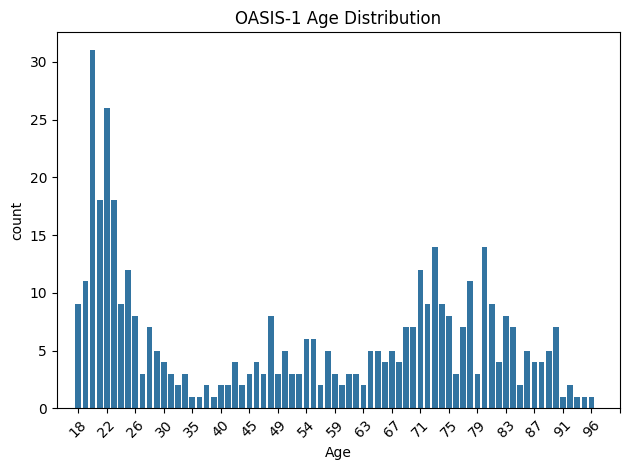

In [243]:
# Age distribution in OASIS-1
class_column1 = df.columns[3]
sns.countplot(x=class_column1, data=df)
plt.title("OASIS-1 Age Distribution")

# Set x-axis limits and ticks from 20 to 100
plt.xlim(-3, 10)
plt.xticks(ticks=range(0, 77, 4), rotation=45)

plt.tight_layout()
plt.show()


# Age Distribuation in OASIS-1

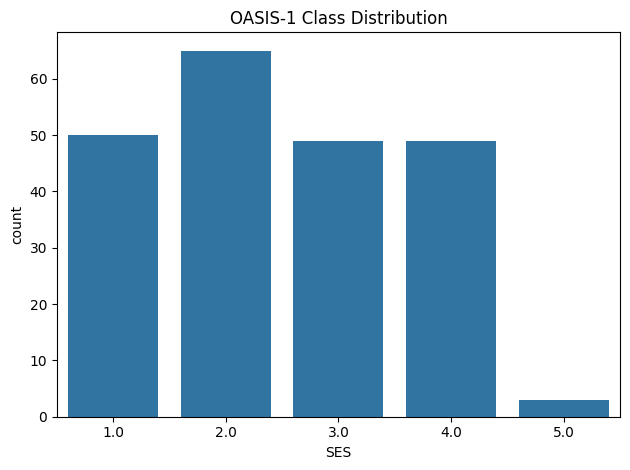

In [244]:
# Age distribution in OASIS-1
class_column1 = df.columns[5]
sns.countplot(x=class_column1, data=df)
plt.title("OASIS-1 Class Distribution")

plt.tight_layout()
plt.show()

# OASIS-1 Summary Statistics, Histograms, and Botplots

,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
count,436.000000,235.000000,216.000000,235.00000,235.000000,436.000000,436.000000,436.000000,20.00000
mean,51.357798,3.178723,2.490741,27.06383,0.285106,1481.919725,0.791670,1.198894,20.55000
std,25.269862,1.311510,1.120593,3.69687,0.383405,158.740866,0.059937,0.128682,23.86249
min,18.000000,1.000000,1.000000,14.00000,0.000000,1123.000000,0.644000,0.881000,1.00000
25%,23.000000,2.000000,2.000000,26.00000,0.000000,1367.750000,0.742750,1.111750,2.75000
50%,54.000000,3.000000,2.000000,29.00000,0.000000,1475.500000,0.809000,1.190000,11.00000
75%,74.000000,4.000000,3.000000,30.00000,0.500000,1579.250000,0.842000,1.284250,30.75000
max,96.000000,5.000000,5.000000,30.00000,2.000000,1992.000000,0.893000,1.563000,89.00000


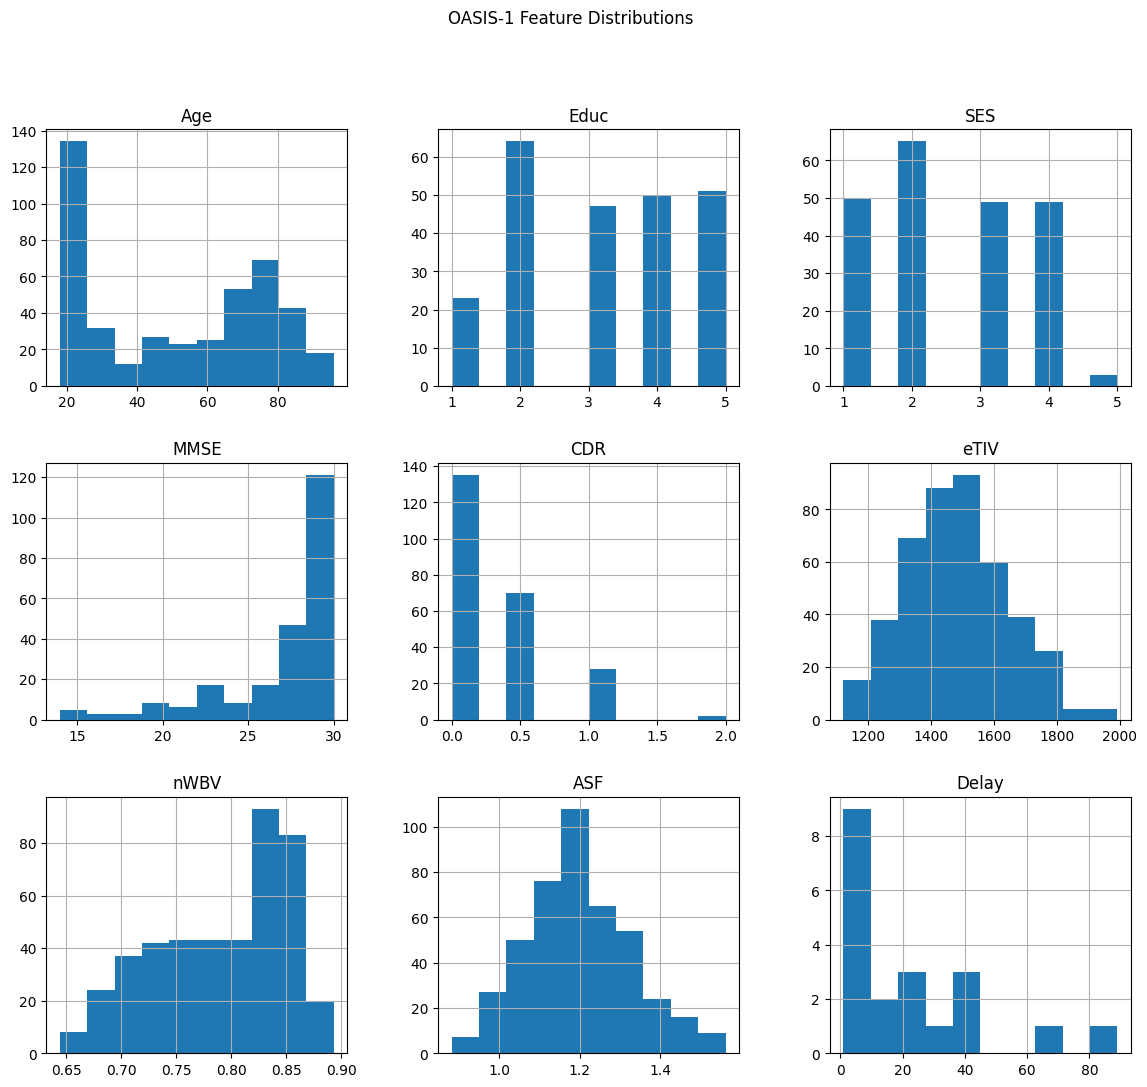

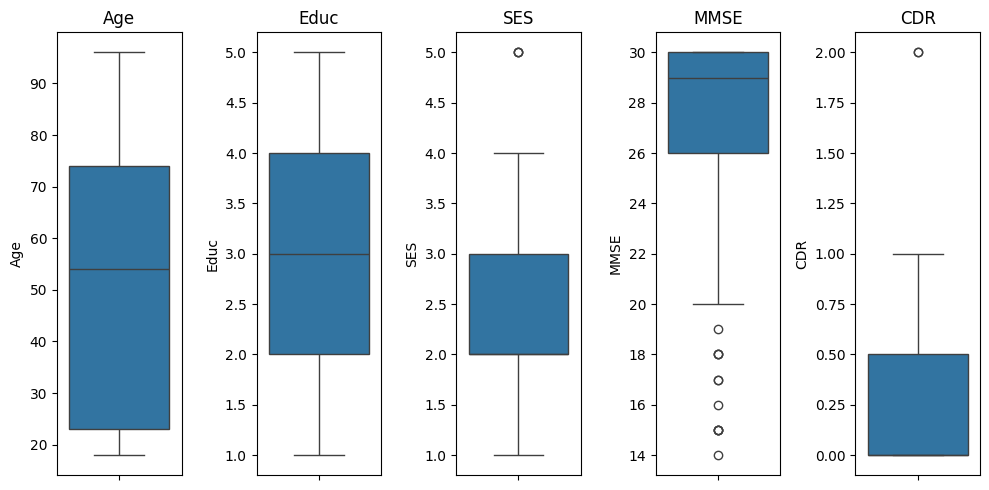

In [245]:
# Display summary statistics for OASIS-1
display(df.describe())

# Histograms for numerical features in OASIS-1
df.hist(figsize=(14, 12))
plt.suptitle("OASIS-1 Feature Distributions")
plt.show()

# Boxplots and subplots for features in OASIS-1
plt.figure(figsize=(10, 5))
num_cols1 = df.select_dtypes(include=np.number).columns
num_cols1 = num_cols1.dropna()  # Drop any NaN columns if they exist
num_cols1 = num_cols1[num_cols1 != 'age']  # Exclude 'age' if it's not needed
num_cols1 = num_cols1[:5]  # Limit to first 8 numerical columns for clarity
for i, col in enumerate(num_cols1):
    plt.subplot(1, 5, i + 1)
    sns.boxplot(y=df[col])
    plt.title(col)
    plt.tight_layout()
plt.show()

# Class Imbalance

As we can see, there is a large class imbalance between the Non-Demented and the Moderate Dementia classes. To fix this, SMOTE and Weighted Random Samplers will be applied to the dataset

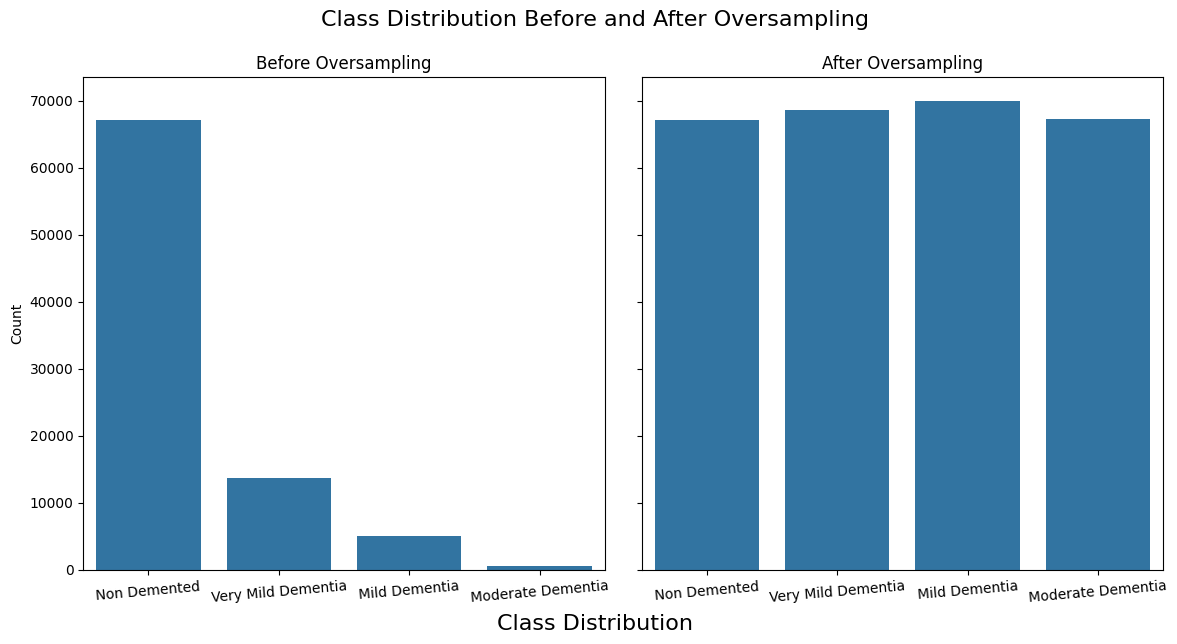

Image Label Distribution Before Oversampling:
label
Non Demented          67222
Very Mild Dementia    13725
Mild Dementia          5002
Moderate Dementia       488
Name: count, dtype: int64

Image Label Distribution After Oversampling:
label
Mild Dementia         70028
Very Mild Dementia    68625
Moderate Dementia     67344
Non Demented          67222
Name: count, dtype: int64


In [246]:
# Solve the class imbalance problem by oversampling the minority class

# Get the counts of each class
class_counts = image_df['label'].value_counts()
# Find the maximum class count

max_count = class_counts.max()
# Create a list to hold the oversampled data
oversampled_data = []
# Loop through each class and oversample the minority classes
for class_label, count in class_counts.items():
    # Get the images for the current class
    class_images = image_df[image_df['label'] == class_label]
    # If the current class is the minority class, oversample it
    if count < max_count:
        # Calculate how many times to duplicate the images
        num_duplicates = max_count // count
        # Duplicate the images and add them to the oversampled data
        for i in range(num_duplicates):
            oversampled_data.append(class_images)
    # Add the original images to the oversampled data
    oversampled_data.append(class_images)

# Concatenate the oversampled data into a single DataFrame
oversampled_df = pd.concat(oversampled_data, ignore_index=True)

# Shuffle the DataFrame to mix the classes
oversampled_df = oversampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Determine a consistent order based on the original dataset
label_order = image_df['label'].value_counts().index.tolist()

# Plot the distribution before and after oversampling with consistent order
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Before oversampling
sns.countplot(x='label', data=image_df, order=label_order, ax=axes[0])
axes[0].set_title("Before Oversampling")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("  ")
axes[0].tick_params(axis='x', rotation=5)

# After oversampling
sns.countplot(x='label', data=oversampled_df, order=label_order, ax=axes[1])
axes[1].set_title("After Oversampling")
axes[1].set_ylabel(" ")
axes[1].set_xlabel(" ")
axes[1].tick_params(axis='x', rotation=5)

plt.tight_layout()
fig.supxlabel("Class Distribution", fontsize=16)
plt.suptitle("Class Distribution Before and After Oversampling", fontsize=16, y=1.05)
plt.show()


# Print the counts of each class before oversampling
print("Image Label Distribution Before Oversampling:")
print(image_df['label'].value_counts())
print("")

# Print the counts of each class after oversampling
print("Image Label Distribution After Oversampling:")
print(oversampled_df['label'].value_counts())



# Splitting Dataset
Now that the class imbalance is solved, all images must be set to a 224 x 224 image resolution in order to normalize the data.

In [247]:
# Normalize the image data
# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

# Create a custom dataset class
class MRIDataset(Dataset):
    def __init__(self, image_df, transform=None):
        self.image_df = image_df  # DataFrame containing image paths and labels
        self.transform = transform

    def __len__(self):
        return len(self.image_df)

    def __getitem__(self, idx):
        # Get image path and label from DataFrame
        image_path = self.image_df.iloc[idx]['image_path']  # Adjust column name as needed
        label = self.image_df.iloc[idx]['label']            # Adjust column name as needed
        
        # Load image (assuming you're using PIL)
        image = Image.open(image_path)
        
        # Apply transforms if specified
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(int(label), dtype=torch.long)

# Ensuring 

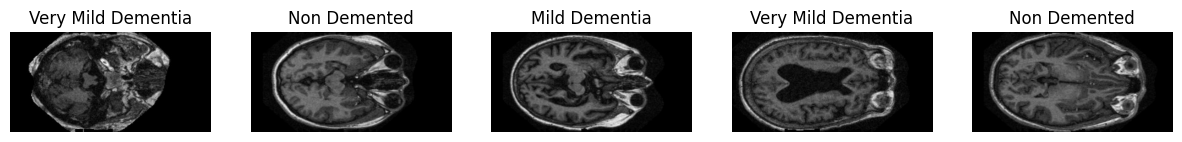

In [248]:
# Before transforming the images, let's check the first few images in the dataset
def display_images(image_df, num_images=5):
    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        image_path = image_df.iloc[i]['image_path']
        label = image_df.iloc[i]['label']
        image = Image.open(image_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')
    plt.show()

# Display the first few images in the dataset
display_images(oversampled_df, num_images=5)


# Transforming the Data
With the Dataset Class and the transformations in place, it is now time to begin the final augmentation.

Size of the dataset: 273219
Label mapping:
{'Non Demented': 0, 'Very Mild Dementia': 1, 'Mild Dementia': 2, 'Moderate Dementia': 3}


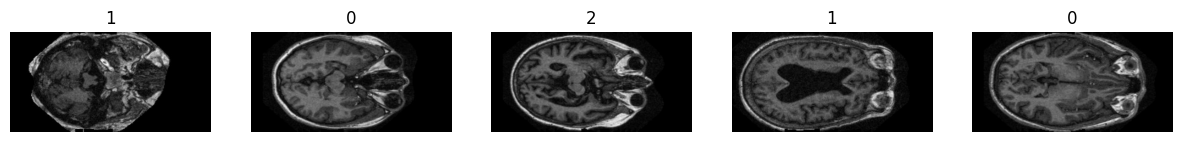

In [249]:
# Begin transforming the images and creating the dataset
train_dataset = MRIDataset(oversampled_df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


# Print out the size of the dataset
print(f"Size of the dataset: {len(train_dataset)}")

# Change the labels to integers ("0" Non Demented, "1 - Very Mild Dementia" , "2" - Mild Dementia, "3" - Moderate Dementia,a)
label_mapping = {
    "Non Demented": 0,
    "Very Mild Dementia": 1,
    "Mild Dementia": 2,
    "Moderate Dementia": 3
}
# Map the labels to integers in the DataFrame
oversampled_df['label'] = oversampled_df['label'].map(label_mapping)

# Print out the mapping of labels to integers
print("Label mapping:")
print(label_mapping)

# Display the first few images in the dataset
display_images(oversampled_df, num_images=5)


# Defining the First Module: ResNet-18

Now we will begin to create the first of the models in this project, ResNet-18. This archteturice is modified to ensure that the data passed through it can be used in the later SHAP anaylsis and CatBoost integration.

In [250]:
# Define the ResNet-18 model wrapper
class ResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet18, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)
    
# Split the dataset into training and validation sets
train_df, val_df = train_test_split(oversampled_df, test_size=0.2, random_state=42, stratify=oversampled_df['label'])

# Create datasets and dataloaders for training and validation
train_dataset = MRIDataset(train_df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = MRIDataset(val_df, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
model = ResNet18(num_classes=len(oversampled_df['label'].unique())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


c:\Users\austi\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\austi\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Define the Training Model

In [251]:
# Save losses and accuracies for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        total = 0
        correct = 0

        # Progress bar for training
        progress = tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False)
        
        # Iterate over the training data
        for images, labels in progress:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            batch_accuracy = accuracy_score(labels.cpu(), predicted.cpu())
            progress.set_postfix(loss=loss.item(), accuracy=batch_accuracy)

        # Calculate average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_total = 0
        val_correct = 0

        # Progress bar for validation
        val_progress = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}", leave=False)

        # Iterate over the validation data
        for images, labels in val_progress:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            val_batch_accuracy = accuracy_score(labels.cpu(), predicted.cpu())
            val_progress.set_postfix(loss=loss.item(), accuracy=val_batch_accuracy)

        # Calculate average validation loss and accuracy
        val_loss /= len(val_loader)
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print epoch statistics 
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_accuracy:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")
    return model

# Begin Training

Running this cell will inciate the training process.

In [252]:
# Take only a fraction of the dataset for training to undersample the data
reduction_factor = 0.5 # Adjust this value to control the size of the reduced dataset, leave at one for full data training

# Split the dataset into training and validation sets
reduced_train_df, reduced_val_df = train_test_split(oversampled_df, test_size=0.2, random_state=42, stratify=oversampled_df['label'])

# Create datasets and dataloaders for training and validation
reduced_train_dataset = MRIDataset(reduced_train_df, transform=transform)
reduced_train_loader = DataLoader(reduced_train_dataset, batch_size=32, shuffle=True)
reduced_val_dataset = MRIDataset(reduced_val_df, transform=transform)
reduced_val_loader = DataLoader(reduced_val_dataset, batch_size=32, shuffle=False)

# Train the model
model = train_model(model, reduced_train_loader, reduced_val_loader, criterion, optimizer, num_epochs=20)

# Save the model
torch.save(model.state_dict(), 'resnet18_model.pth')


Epoch [1/20] | Train Loss: 0.0701 | Train Acc: 0.9740 | Val Loss: 0.0114 | Val Acc: 0.9960


Epoch [2/20] | Train Loss: 0.0130 | Train Acc: 0.9958 | Val Loss: 0.0106 | Val Acc: 0.9959


Epoch [3/20] | Train Loss: 0.0081 | Train Acc: 0.9975 | Val Loss: 0.0015 | Val Acc: 0.9995


Epoch [4/20] | Train Loss: 0.0057 | Train Acc: 0.9983 | Val Loss: 0.0125 | Val Acc: 0.9962


Epoch [5/20] | Train Loss: 0.0044 | Train Acc: 0.9988 | Val Loss: 0.0001 | Val Acc: 1.0000


Epoch [6/20] | Train Loss: 0.0031 | Train Acc: 0.9991 | Val Loss: 0.0015 | Val Acc: 0.9995


Epoch [7/20] | Train Loss: 0.0026 | Train Acc: 0.9991 | Val Loss: 0.0002 | Val Acc: 0.9999


Epoch [8/20] | Train Loss: 0.0029 | Train Acc: 0.9992 | Val Loss: 0.0005 | Val Acc: 0.9999


Epoch [9/20] | Train Loss: 0.0020 | Train Acc: 0.9994 | Val Loss: 0.0001 | Val Acc: 1.0000


Epoch [10/20] | Train Loss: 0.0019 | Train Acc: 0.9994 | Val Loss: 0.0009 | Val Acc: 0.9997


Epoch [11/20] | Train Loss: 0.0019 | Train Acc: 0.9994 | Val Loss: 0.0001 | Val Acc: 1.0000


Epoch [12/20] | Train Loss: 0.0016 | Train Acc: 0.9994 | Val Loss: 0.0028 | Val Acc: 0.9992


Epoch [13/20] | Train Loss: 0.0013 | Train Acc: 0.9996 | Val Loss: 0.0000 | Val Acc: 1.0000


Epoch [14/20] | Train Loss: 0.0014 | Train Acc: 0.9996 | Val Loss: 0.0000 | Val Acc: 1.0000


Epoch [15/20] | Train Loss: 0.0013 | Train Acc: 0.9997 | Val Loss: 0.0007 | Val Acc: 0.9997


Epoch [16/20] | Train Loss: 0.0008 | Train Acc: 0.9997 | Val Loss: 0.0006 | Val Acc: 0.9998


Epoch [17/20] | Train Loss: 0.0012 | Train Acc: 0.9997 | Val Loss: 0.0000 | Val Acc: 1.0000


Epoch [18/20] | Train Loss: 0.0010 | Train Acc: 0.9998 | Val Loss: 0.0001 | Val Acc: 1.0000


Epoch [19/20] | Train Loss: 0.0012 | Train Acc: 0.9997 | Val Loss: 0.0060 | Val Acc: 0.9979


Epoch [20/20] | Train Loss: 0.0007 | Train Acc: 0.9998 | Val Loss: 0.0003 | Val Acc: 0.9999


# Evaluating ResNet-18


Model summary:
ResNet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

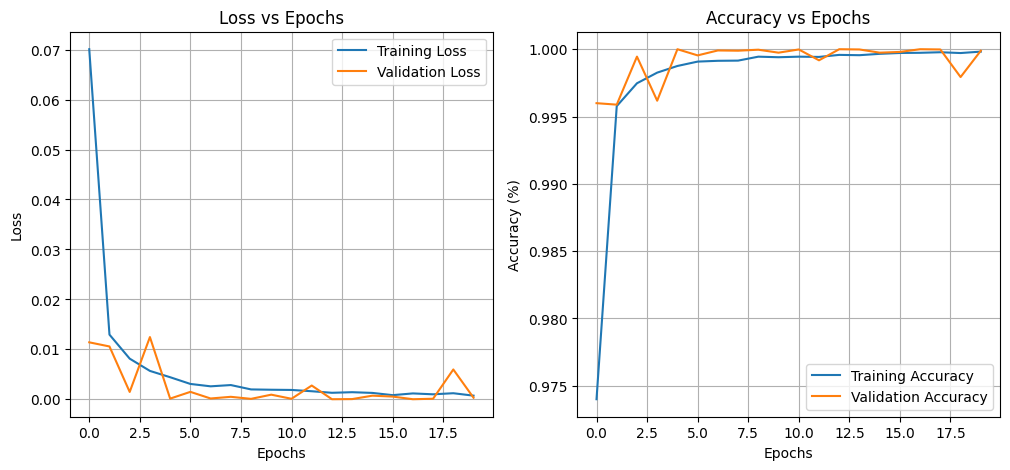

In [253]:
# Print out the model summary
print("Model summary:")
print(model)

# Plot the training and validation losses and accuracies
plt.figure(figsize=(12, 5))

# Plot training and validation losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()


# Test Set, Classification Report, and Confusion Matrix

In [254]:
# The original oasis-1 dataset is labeled as "image_df" and the oversampled dataset is labeled as "oversampled_df",
# image_df will serve as the test set for the model.

# Change the labels to integers ("0" Non Demented, "1 - Very Mild Dementia" , "2" - Mild Dementia, "3" - Moderate Dementia, "4")
image_df['label'] = image_df['label'].map(label_mapping)

# Create a test dataset and dataloader
test_dataset = MRIDataset(image_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model on the test set
def evaluate_model(model, loader):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []
    all_probs = []

    # Progress bar for testing
    progress = tqdm(loader, desc="Testing", leave=False)

    # Iterate over the test data
    for images, labels in progress:
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(images)
            probs = nn.Softmax(dim=1)(outputs)  # Get probabilities
            _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

# Evaluate the model on the test set
test_labels, test_preds, test_probs = evaluate_model(model, test_loader)

# Evaluate the model on the validation set
val_labels, val_preds, val_probs = evaluate_model(model, reduced_val_loader)

# Calculate accuracy
accuracy = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 1.0000


# ResNet-18 Classification Report

In [255]:
# Label for dataset correspond to the following:
# 0 - Non Demented
# 1 - Very Mild Dementia
# 2 - Mild Dementia
# 3 - Moderate Dementia

# Give a new set of labels to the dataset 
label_mapping = {0: "Non Demented", 1: "Very Mild Dementia", 2: "Mild Dementia", 3: "Moderate Dementia"}

# Print classification report for the test set
print("Classification Report - Test Set:")
print(classification_report(test_labels, test_preds, target_names=[label_mapping[i] for i in range(len(label_mapping))]))

# Print classification report for the validation set
print("Classification Report - Validation Set:")
print(classification_report(val_labels, val_preds, target_names=[label_mapping[i] for i in range(len(label_mapping))]))

Classification Report - Test Set:
                    precision    recall  f1-score   support

      Non Demented       1.00      1.00      1.00     67222
Very Mild Dementia       1.00      1.00      1.00     13725
     Mild Dementia       1.00      1.00      1.00      5002
 Moderate Dementia       1.00      1.00      1.00       488

          accuracy                           1.00     86437
         macro avg       1.00      1.00      1.00     86437
      weighted avg       1.00      1.00      1.00     86437

Classification Report - Validation Set:
                    precision    recall  f1-score   support

      Non Demented       1.00      1.00      1.00     13444
Very Mild Dementia       1.00      1.00      1.00     13725
     Mild Dementia       1.00      1.00      1.00     14006
 Moderate Dementia       1.00      1.00      1.00     13469

          accuracy                           1.00     54644
         macro avg       1.00      1.00      1.00     54644
      weighted avg   

# ResNet-18 Confusion Matrix

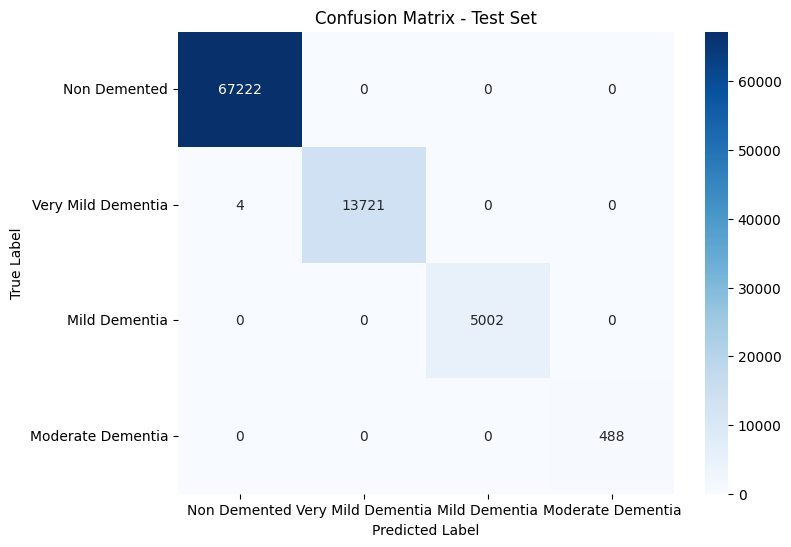

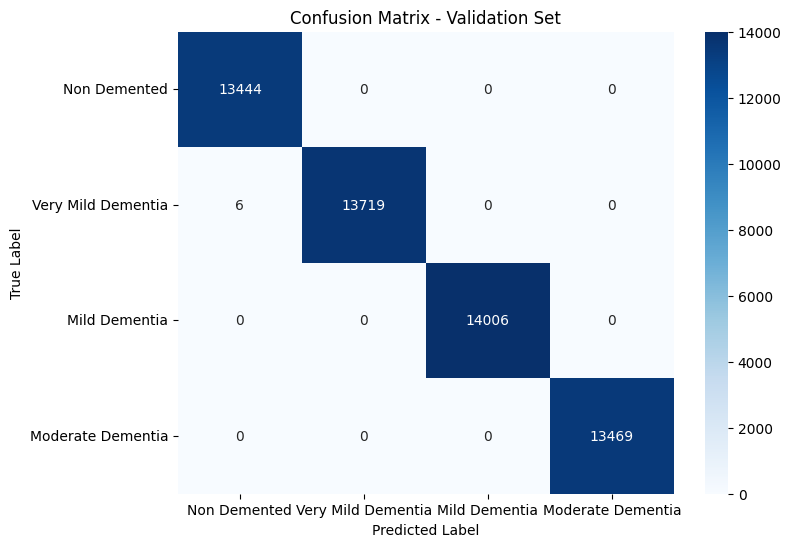

In [256]:
# Print confusion matrix of the test set
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[label_mapping[i] for i in range(len(label_mapping))], yticklabels=[label_mapping[i] for i in range(len(label_mapping))])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print confusion matrix of the validation set
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[label_mapping[i] for i in range(len(label_mapping))], yticklabels=[label_mapping[i] for i in range(len(label_mapping))])
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Stats


ROC AUC Score (Micro): 1.0000


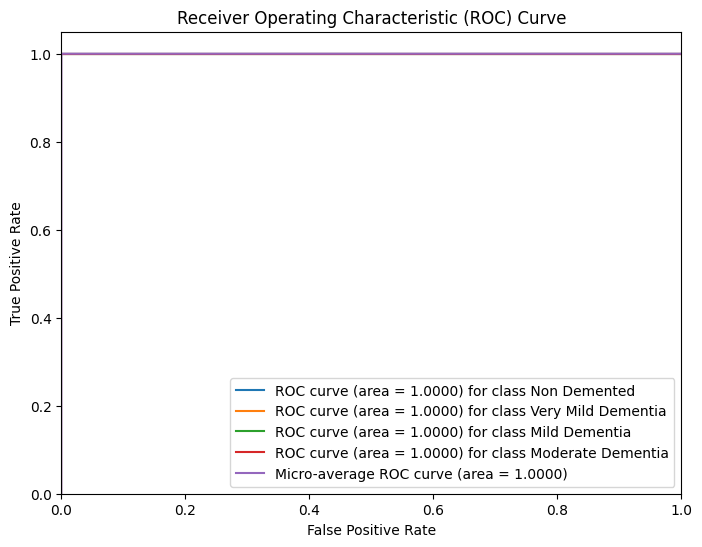

Average Precision: 1.0000


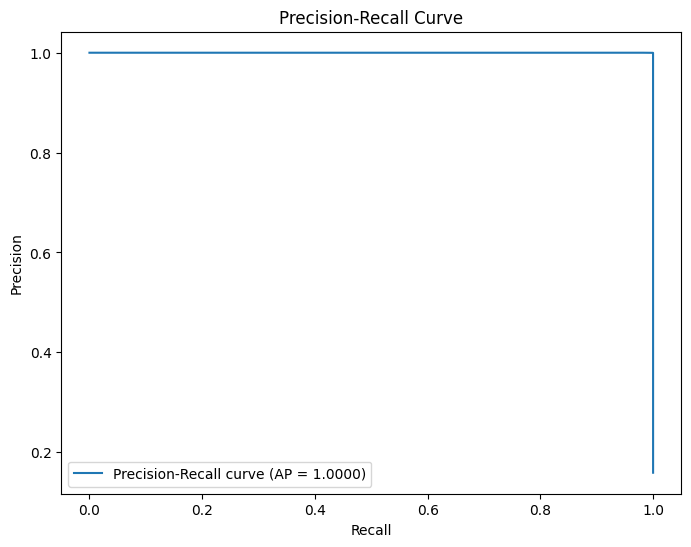

In [257]:
# Statistics of the model, roc curve, and precision-recall curve
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_labels, test_probs[:, 1], pos_label=1)

# Calculate ROC AUC score for multiclass classification
# Note: For multiclass, you may need to use OneVsRestClassifier or similar approach
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve

# Binarize the output labels for multiclass ROC AUC calculation
test_labels_bin = label_binarize(test_labels, classes=[0, 1, 2, 3])
n_classes = test_labels_bin.shape[1]
# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_probs[:, i])
    roc_auc[i] = roc_auc_score(test_labels_bin[:, i], test_probs[:, i])
# Compute micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_bin.ravel(), test_probs.ravel())
roc_auc["micro"] = roc_auc_score(test_labels_bin, test_probs, average="micro")
print(f"ROC AUC Score (Micro): {roc_auc['micro']:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.4f}) for class {label_mapping[i]}')
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate Precision-Recall curve and AUC
precision, recall, thresholds = precision_recall_curve(test_labels, test_probs[:, 1], pos_label=1)
average_precision = average_precision_score(test_labels, test_probs)
print(f"Average Precision: {average_precision:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AP = {average_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


# ResNet-18 and SHAP values
 
Now we can begin applying SHAP to our model by using the Partition explainer.

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 1/4 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 3/4 [00:41<00:10, 10.27s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 4/4 [01:01<00:00, 14.52s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 5it [01:21, 20.46s/it]                       


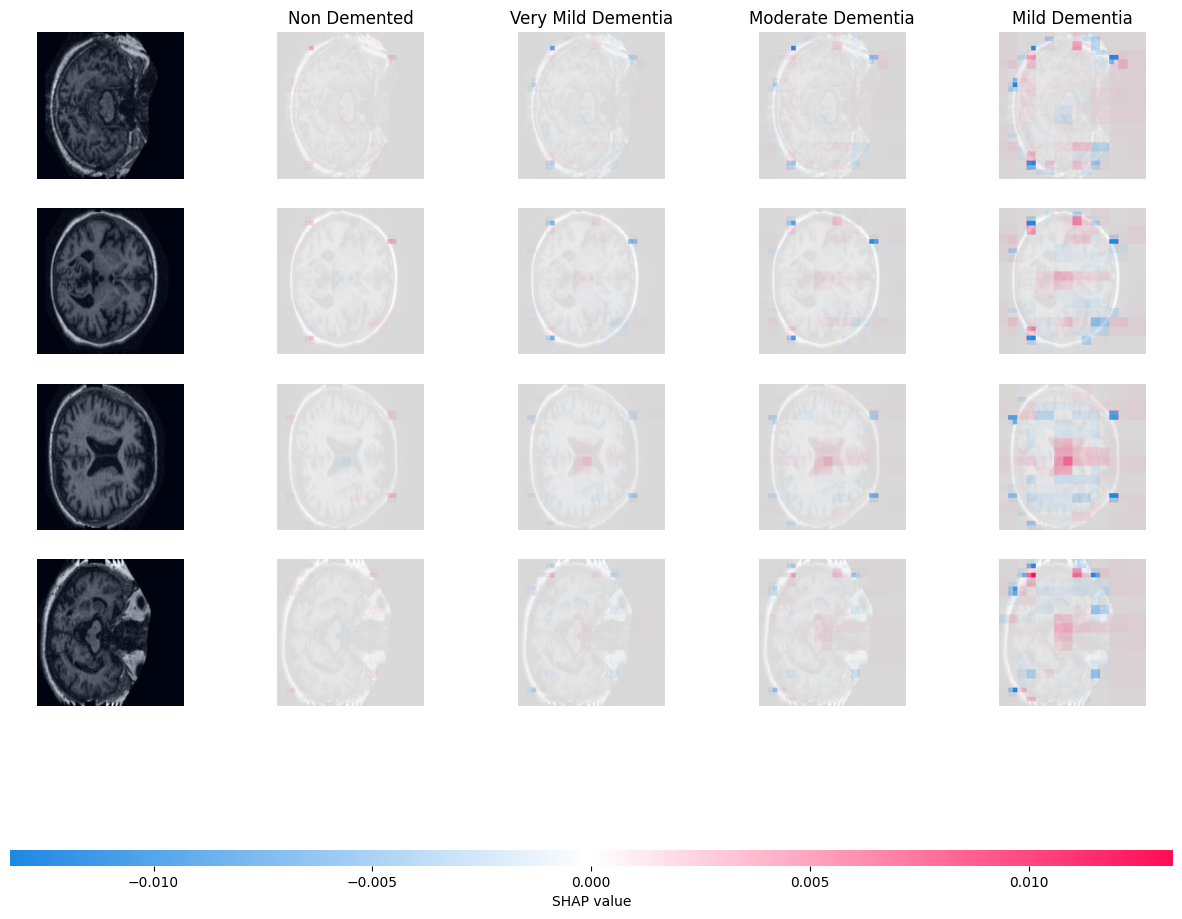

In [265]:
# Get class names from your label mapping
class_names = [label_mapping[i] for i in range(len(label_mapping))]

# Define SHAP masker
masker = shap.maskers.Image("inpaint_telea", shape=(224, 224, 3))

# Define model prediction function for SHAP
def model_predict(images_np):
    images_tensor = torch.from_numpy(images_np.transpose(0, 3, 1, 2)).float().to(device) / 255.0
    model.eval()
    with torch.no_grad():
        outputs = model(images_tensor)
    return outputs.cpu().numpy()

# Collect the first image of each class
seen_classes = set()
selected_images = []

# Iterate through the dataset and select one image from each class
for i in range(len(train_dataset)):
    image, label = train_dataset[i]
    if label not in seen_classes:
        selected_images.append(image)
        seen_classes.add(label)
    if len(seen_classes) == len(class_names):
        break

# Convert the list of images to a tensor
images = torch.stack(selected_images)

# Convert to HWC and uint8
images_np = images.permute(0, 2, 3, 1).numpy()
images_np = (images_np - images_np.min()) / (images_np.max() - images_np.min())
images_np = (images_np * 255).astype(np.uint8)

# Create the SHAP explainer
explainer = shap.Explainer(model_predict, masker, output_names=class_names)

# Compute SHAP values for the batch
shap_values = explainer(images_np, max_evals=1000, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

# Plot SHAP explanations
shap.image_plot(shap_values, images_np)


# Passing the SHAP values to Sequential Model

In [271]:

all_image_paths = []
all_patient_ids = []

# Gather one image per patient
for patient_id in df['ID'].unique():
    pattern = f"Data/*/{patient_id}_*.jpg"
    matches = glob.glob(pattern)
    if matches:
        first_image_path = sorted(matches)[0]
        all_image_paths.append(first_image_path)
        all_patient_ids.append(patient_id)

# Process in one batch
all_images = []
for image_path in all_image_paths:
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    all_images.append(image)
all_images = torch.stack(all_images).to(device)

# Print size of the dataset
print(f"Size of the dataset: {len(all_images)}")

# Convert to HWC and uint8
all_images_np = all_images.permute(0, 2, 3, 1).cpu().numpy()
all_images_np = (all_images_np - all_images_np.min()) / (all_images_np.max() - all_images_np.min())
all_images_np = (all_images_np * 255).astype(np.uint8)

Size of the dataset: 200


# Generating the SHAP values for the Dataset

PartitionExplainer explainer: 201it [15:45,  4.77s/it]                         


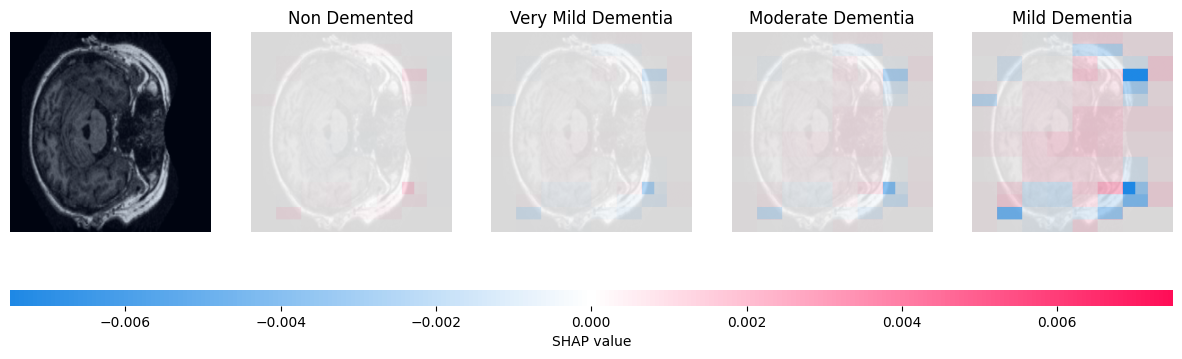

In [268]:
# Create the SHAP explainer
explainer = shap.Explainer(model_predict, masker, output_names=class_names)
# Compute SHAP values for the batch
shap_values = explainer(all_images_np, max_evals=250, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

# Plot SHAP explanations for the first image
shap.image_plot(shap_values[0], all_images_np[0])
# Plot SHAP explanations for the first image

# Reduce each SHAP explanation to a feature vector (e.g., mean absolute SHAP values per class)
shap_vectors = np.abs(shap_values.values).mean(axis=(2, 3, 4))  # shape: (num_samples, num_outputs)

# save the SHAP values to a numpy file
np.save("shap_values.npy", shap_vectors)

# Non-Imaging Model: Loading and Preprossing the Data

In [269]:
# Hyperparameters
LR = 1e-3
DROPOUT_P = 0.3
EPOCHS = 1000

# Loading in the dataset
FILE = "oasis_cross-sectional.xlsx"
df = pd.read_excel(FILE)

# Filter rows with valid CDR values and map to labels
cdr_to_label = {0.0: 0, 0.5: 1, 1.0: 2, 2.0: 3}
df = df[df["CDR"].isin(cdr_to_label.keys())].copy()
df["label"] = df["CDR"].map(cdr_to_label).astype(int)

# Define feature columns
numeric_cols = ["Age", "Educ", "MMSE", "ASF", "eTIV", "nWBV"]
categorical_cols = ["M/F", "Hand"]

# Drop rows with missing values
df = df.dropna(subset=numeric_cols + categorical_cols).reset_index(drop=True)

# Preprocessing pipelines
numeric_xf = Pipeline([("scaler", StandardScaler())])
categorical_xf = Pipeline([("ohe", OneHotEncoder(drop="first"))])
pre = ColumnTransformer(
    [("num", numeric_xf, numeric_cols),
     ("cat", categorical_xf, categorical_cols)]
)

# Prepare features and labels
X = pre.fit_transform(df)
y = df["label"].values

# Split data into training and validation sets
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Convert to PyTorch tensors
X_tr = torch.tensor(X_tr, dtype=torch.float32)
y_tr = torch.tensor(y_tr, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

# Create TensorDatasets and DataLoaders
train_ds = TensorDataset(X_tr, y_tr)
val_ds = TensorDataset(X_val, y_val)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64)


# Non-Imaging: Loading SHAP Image Features

In [272]:
# Get patient IDs with SHAP values
shap_patient_ids = np.array(all_patient_ids)  # from SHAP generation script

# Filter the original dataframe
df_filtered = df[df["ID"].isin(shap_patient_ids)].reset_index(drop=True)

# Re-extract X and y from df_filtered
X = pre.transform(df_filtered)
y = df_filtered["label"].values

# Load SHAP features
shap_features = np.load("shap_values.npy")

# Verify alignment
assert X.shape[0] == shap_features.shape[0], "Still mismatched after filtering!"

# Combine features
X_combined = np.concatenate([X, shap_features], axis=1)
X_combined = torch.tensor(X_combined, dtype=torch.float32)



# Non-Imaginging: Model Definition

In [275]:
class DementiaModel(nn.Module):
    def __init__(self, input_dim, num_classes=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)  # multi-class output
        )

    def forward(self, x):
        return self.net(x)

in_dim = X_combined.shape[1]  # Match actual input feature siz
output_dim = len(np.unique(y))  # Number of classes
model = DementiaModel(input_dim=in_dim).to(device)

# Non-Imaging: Training the Sequential Model

In [276]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
train_loss_hist, val_loss_hist, val_acc_hist = [], [], []

for epoch in range(1, EPOCHS + 1):
    model.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

    train_loss_hist.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for xb_val, yb_val in val_dl:
            xb_val, yb_val = xb_val.to(device), yb_val.to(device)
            logits = model(xb_val)
            loss = criterion(logits, yb_val)
            val_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            total += yb_val.size(0)
            correct += (predicted == yb_val).sum().item()

        val_loss /= len(val_dl)
        val_acc = correct / total
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | train_loss={loss.item():.4f} "
              f"| val_loss={val_loss:.4f} | val_acc={val_acc:.4f}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x7 and 231x128)

# Evaluating Final Model

In [ ]:
# Confusion Matrix
model.eval()
with torch.no_grad():
    yhat_val = torch.argmax(model(X_val.to(device)), dim=1).cpu().numpy()

cm = confusion_matrix(y, yhat_val)
plt.figure()
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (Full Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
for i in range(output_dim):
    for j in range(output_dim):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=12)
plt.xticks(np.arange(output_dim), ["Non Demented", "Very Mild", "Mild", "Moderate"])
plt.yticks(np.arange(output_dim), ["Non Demented", "Very Mild", "Mild", "Moderate"])
plt.colorbar()
plt.show()

# Classification Report
print("Classification report on validation set:")
print(classification_report(y, yhat_val, target_names=["Non Demented", "Very Mild", "Mild", "Moderate"]))

# ROC Curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the output labels for multiclass ROC AUC calculation
y_bin = label_binarize(y, classes=[0, 1, 2, 3])
n_classes = y_bin.shape[1]
# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], yhat_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), yhat_val.ravel())
roc_auc["micro"] = roc_auc_score(y_bin, yhat_val, average="micro")
# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.4f}) for class {label_mapping[i]}')
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

